In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, skew, kurtosis
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, auc, f1_score)

sns.set(style="whitegrid")

In [3]:
csv_path = 'AswanData_weatherdata.csv' 
df = pd.read_csv(csv_path)
    

df.columns = [c.strip() for c in df.columns] #remove extra space


rename_map = {
    'AvgTemperture': 'AvgTemp',   
    'AverageDew(point via humidity)': 'DewPoint',
    'Solar(PV)': 'Solar_PV'
}
df.rename(columns=rename_map, inplace=True)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


df['Month'] = df['Date'].dt.month #extract month from date


df = df.sort_values('Date').reset_index(drop=True) #Sort the data by date

#handle missing values by interpolation
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Shape: (398, 9)
Columns: ['Unnamed: 0', 'Date', 'AvgTemp', 'DewPoint', 'Humidity', 'Wind', 'Pressure', 'Solar_PV', 'Month']


,Unnamed: 0,Date,AvgTemp,DewPoint,Humidity,Wind,Pressure,Solar_PV,Month
0,392,2021-04-01,80.0,29.4,16.7,10.9,29.2,31.214857,4
1,393,2021-04-02,79.7,31.3,18.1,10.3,29.2,34.046000,4
2,394,2021-04-03,77.2,30.4,20.7,10.8,29.2,34.187143,4
3,395,2021-04-04,73.1,25.1,17.3,9.0,29.2,31.442286,4
4,396,2021-04-05,85.6,26.3,11.8,7.6,29.2,31.606571,4


In [4]:
# Binning 

df['Solar_Class'] = pd.qcut(df['Solar_PV'], q=3, labels=['Low', 'Medium', 'High']) #create 3 equal-frequency bins for solar PV (target variable)

df['Temp_Bin'] = pd.cut(df['AvgTemp'], bins=[0, 70, 85, 120], labels=['Cool', 'Mild', 'Hot']) #create temperature bins

print("Target Distribution (Solar_Class):")
print(df['Solar_Class'].value_counts())

Target Distribution (Solar_Class):
Solar_Class
Low       133
High      133
Medium    132
Name: count, dtype: int64



--- Descriptive Statistics ---


,Mean,Std,Skew,Kurtosis,Variance,Min,Max
AvgTemp,81.846482,13.613097,-0.528708,-0.903930,185.316398,51.100000,102.700000
Humidity,22.968090,9.756598,0.731028,-0.414197,95.191196,7.400000,47.700000
Wind,10.146734,2.509152,0.223224,-0.182979,6.295846,4.400000,17.100000
Pressure,29.183040,0.140241,0.448676,-0.633823,0.019668,28.900000,29.600000
Solar_PV,24.375258,7.507561,0.108514,-1.288024,56.363466,8.581429,40.038857



--- Covariance Matrix ---


,AvgTemp,Humidity,Wind,Pressure,Solar_PV
AvgTemp,185.316398,-97.565591,4.516890,-1.498763,3.687807
Humidity,-97.565591,95.191196,2.206180,0.869168,-7.919480
Wind,4.516890,2.206180,6.295846,0.007306,3.154827
Pressure,-1.498763,0.869168,0.007306,0.019668,0.045945
Solar_PV,3.687807,-7.919480,3.154827,0.045945,56.363466


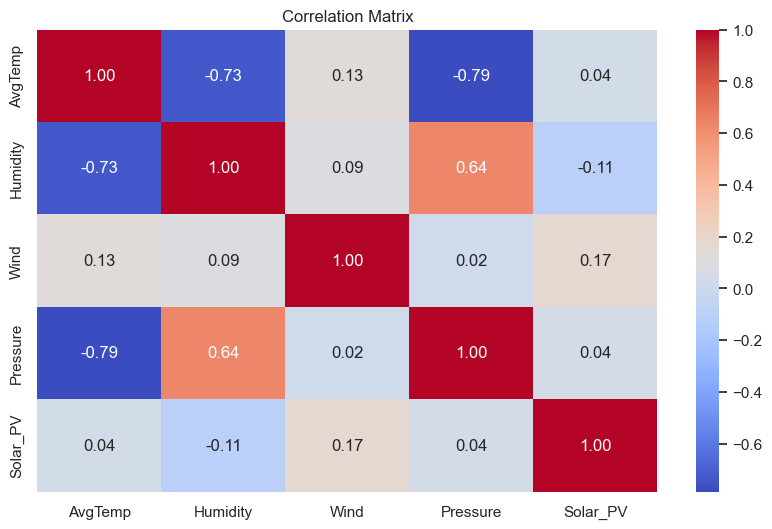

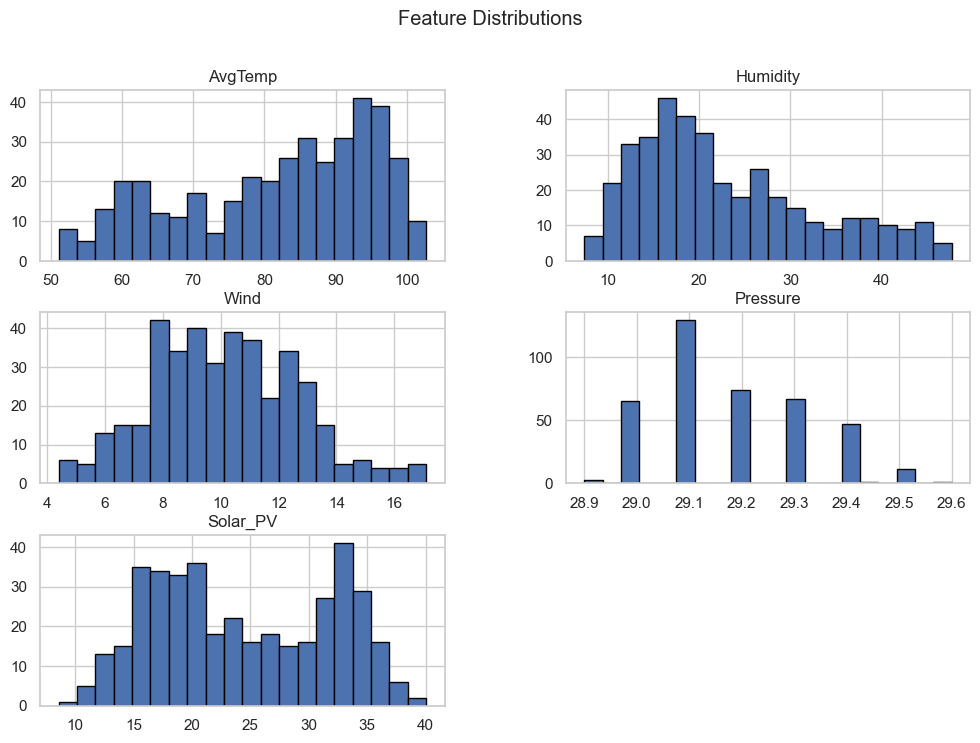

In [5]:
# Statistical Analysis
features_to_analyze = ['AvgTemp', 'Humidity', 'Wind', 'Pressure', 'Solar_PV']

stats_df = pd.DataFrame({
    'Mean': df[features_to_analyze].mean(),
    'Std': df[features_to_analyze].std(),
    'Skew': df[features_to_analyze].skew(), #asymmetry measure
    'Kurtosis': df[features_to_analyze].kurtosis(), #outlier measure
    'Variance': df[features_to_analyze].var(),
    'Min': df[features_to_analyze].min(),
    'Max': df[features_to_analyze].max(),
})
print("\n--- Descriptive Statistics ---")
display(stats_df)


print("\n--- Covariance Matrix ---")
cov_matrix = df[features_to_analyze].cov() # measure of how much two random variables vary together
display(cov_matrix)


plt.figure(figsize=(10, 6))
sns.heatmap(df[features_to_analyze].corr(), annot=True, cmap='coolwarm', fmt=".2f") 
plt.title("Correlation Matrix")
plt.show()


df[features_to_analyze].hist(figsize=(12, 8), bins=20, edgecolor='black') #histograms for feature distributions
plt.suptitle("Feature Distributions")
plt.show()

In [6]:
# hypothesis tests
from scipy.stats import chi2_contingency, f_oneway, ttest_ind, norm
import numpy as np

print("--- Statistical Hypothesis Tests ---\n")

# 1 CHI-SQUARE (check if independent)
contingency = pd.crosstab(df['Temp_Bin'], df['Solar_Class']) #check independence between temperature bins and solar class
chi2, p_chi, dof, ex = chi2_contingency(contingency)
print(f"1. Chi-Square Test: p-value = {p_chi:.4e}")
print(f"   Conclusion: {'Dependent (Significant)' if p_chi < 0.05 else 'Independent'}")


# 2 ANOVA (check if humidity differs by solar class)
groups = [df[df['Solar_Class'] == cls]['Humidity'] for cls in ['Low', 'Medium', 'High']] #Check if humidity differs between Low/Medium/High Solar
f_stat, p_anova = f_oneway(*groups)
print(f"\n2. ANOVA Test: p-value = {p_anova:.4e}")
print(f"   Conclusion: {'Significant Difference among groups' if p_anova < 0.05 else 'No Difference'}")


# 3 T-TEST (compare AvgTemp between Low and High Solar classes)
group_low = df[df['Solar_Class'] == 'Low']['AvgTemp']
group_high = df[df['Solar_Class'] == 'High']['AvgTemp']

t_stat, p_ttest = ttest_ind(group_low, group_high)
print(f"\n3. T-Test (Low vs High Solar): p-value = {p_ttest:.4e}")
print(f"   Conclusion: {'Significant Difference' if p_ttest < 0.05 else 'No Difference'}")


# 4 Z-TEST (average temperature vs population mean)
population_mean_hypothesis = 75 
sample = df['AvgTemp']
mean_sample = sample.mean()
std_error = sample.std() / np.sqrt(len(sample))

z_score = (mean_sample - population_mean_hypothesis) / std_error
p_ztest = 2 * (1 - norm.cdf(abs(z_score))) 

print(f"\n4. Z-Test (vs Hypoth. Mean of 75F): p-value = {p_ztest:.4e}")
print(f"   Sample Mean: {mean_sample:.2f}")
print(f"   Conclusion: {'Significant Difference' if p_ztest < 0.05 else 'Matches Population'}")

--- Statistical Hypothesis Tests ---

1. Chi-Square Test: p-value = 2.4863e-03
   Conclusion: Dependent (Significant)

2. ANOVA Test: p-value = 4.3785e-03
   Conclusion: Significant Difference among groups

3. T-Test (Low vs High Solar): p-value = 2.7706e-01
   Conclusion: No Difference

4. Z-Test (vs Hypoth. Mean of 75F): p-value = 0.0000e+00
   Sample Mean: 81.85
   Conclusion: Significant Difference


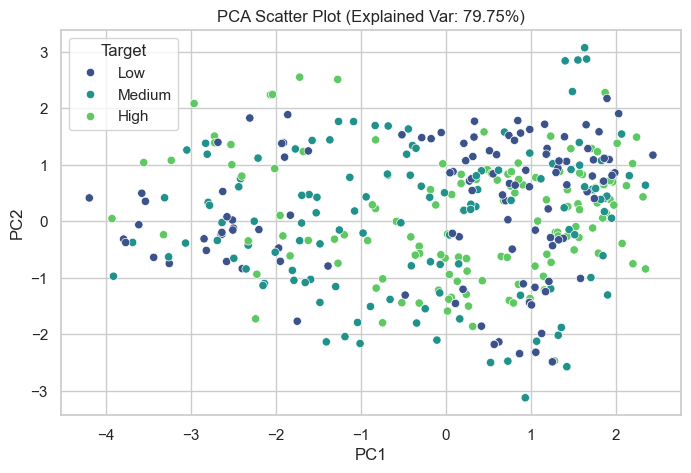

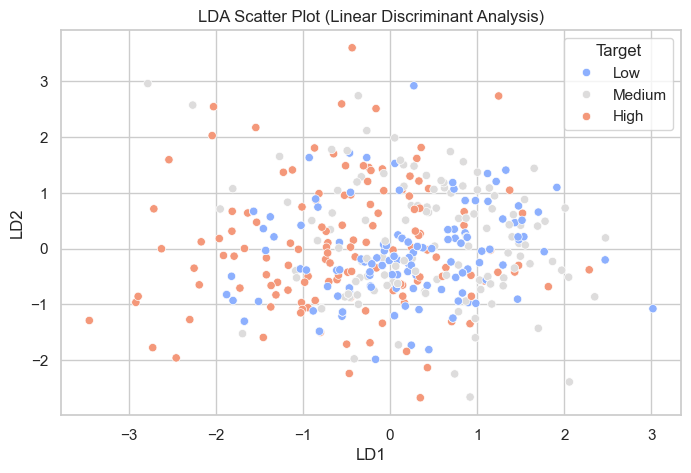

In [7]:
X_viz = df[['AvgTemp', 'Humidity', 'Wind', 'Pressure', 'DewPoint']].copy() #Select features for dimensionality reduction
y_viz = df['Solar_Class']

scaler = StandardScaler() # (features must be same scale for PCA and LDA)
X_scaled = scaler.fit_transform(X_viz)

# 1 PCA Visualization (looks for directions of maximum variance)
pca = PCA(n_components=2)  #Reduce data to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = y_viz

plt.figure(figsize=(8, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Target', palette='viridis')
plt.title(f"PCA Scatter Plot (Explained Var: {sum(pca.explained_variance_ratio_):.2%})")
plt.show()

# 2 LDA Visualization (seeks directions that maximize class separability)
lda = LinearDiscriminantAnalysis(n_components=2) #Reduce to 2 components for visualization
X_lda = lda.fit_transform(X_scaled, y_viz)
lda_df = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
lda_df['Target'] = y_viz

plt.figure(figsize=(8, 5))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Target', palette='coolwarm')
plt.title("LDA Scatter Plot (Linear Discriminant Analysis)")
plt.show()

In [8]:
# Data Preparation
feature_cols = ['AvgTemp', 'Humidity', 'Wind', 'Pressure', 'DewPoint', 'Month']
X = df[feature_cols].copy()

label_map = {'Low': 0, 'Medium': 1, 'High': 2}
y = df['Solar_Class'].map(label_map)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

print(f"Training Features: {X_train.shape}")
print(f"Testing Features:  {X_test.shape}")

Training Features: (318, 6)
Testing Features:  (80, 6)


--- MODEL RESULTS ---

Model: Naive Bayes
Test Acc:   42.50%
Error Rate: 57.50%
Precision:  0.4778
Recall:     0.4250
F1 Score:   0.3784
ROC:    0.6079
------------------------------


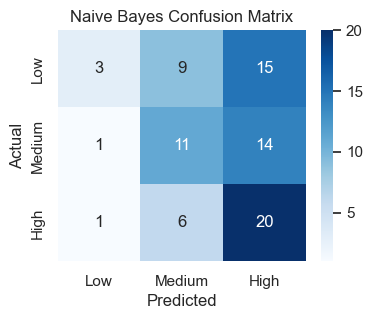


Model: Decision Tree
Test Acc:   65.00%
Error Rate: 35.00%
Precision:  0.6482
Recall:     0.6500
F1 Score:   0.6462
ROC:    0.8240
------------------------------


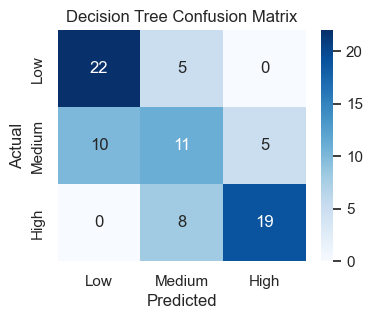


Model: LDA
Test Acc:   47.50%
Error Rate: 52.50%
Precision:  0.4723
Recall:     0.4750
F1 Score:   0.4670
ROC:    0.6547
------------------------------


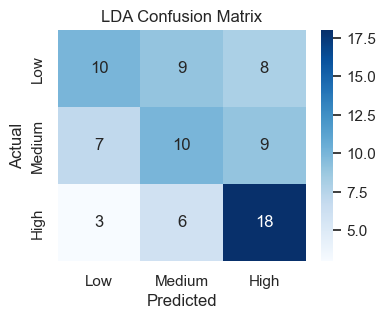


Model: KNN (Euclidean)
Test Acc:   56.25%
Error Rate: 43.75%
Precision:  0.5600
Recall:     0.5625
F1 Score:   0.5496
ROC:    0.7662
------------------------------


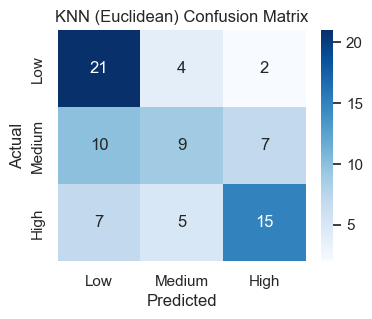


Model: KNN (Manhattan)
Test Acc:   56.25%
Error Rate: 43.75%
Precision:  0.5606
Recall:     0.5625
F1 Score:   0.5506
ROC:    0.7729
------------------------------


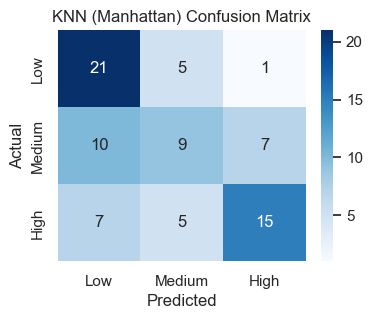


Model: KNN (Minkowski)
Test Acc:   56.25%
Error Rate: 43.75%
Precision:  0.5600
Recall:     0.5625
F1 Score:   0.5496
ROC:    0.7662
------------------------------


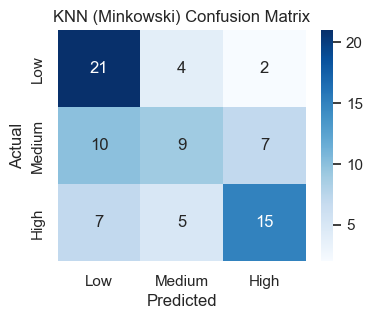


Model: PCA + LogReg
Test Acc:   30.00%
Error Rate: 70.00%
Precision:  0.2616
Recall:     0.3000
F1 Score:   0.2591
ROC:    0.4595
------------------------------


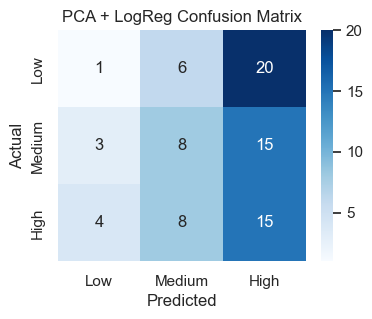

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

models = {
    'Naive Bayes': GaussianNB(), #Calculates probability of each class given the input
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42), # splits the data based on feature values to form a tree of decisions
    'LDA': LinearDiscriminantAnalysis(), # finds linear combinations of features that best separate classes
    'KNN (Euclidean)': KNeighborsClassifier(n_neighbors=7, metric='euclidean'), #Straight line distance
    'KNN (Manhattan)': KNeighborsClassifier(n_neighbors=7, metric='manhattan'), #Grid based distance
    'KNN (Minkowski)': KNeighborsClassifier(n_neighbors=7, metric='minkowski'), #Generalized distance
    'PCA + LogReg': Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=2)), 
        ('logreg', LogisticRegression(max_iter=1000))
    ])
}

results_data = {} 
class_names = ['Low', 'Medium', 'High']

print("--- MODEL RESULTS ---")

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        auc_val = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
    else:
        auc_val = 0.0
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    err = 1 - test_acc
    prec = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    cm = confusion_matrix(y_test, y_test_pred)
    
    
    results_data[name] = {'model': model, 'y_pred': y_test_pred}
    

    print(f"\nModel: {name}")
    print(f"Test Acc:   {test_acc:.2%}")
    print(f"Error Rate: {err:.2%}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1 Score:   {f1:.4f}")
    print(f"ROC:    {auc_val:.4f}")
    print("-" * 30)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('Actual'); plt.xlabel('Predicted')
    plt.show()

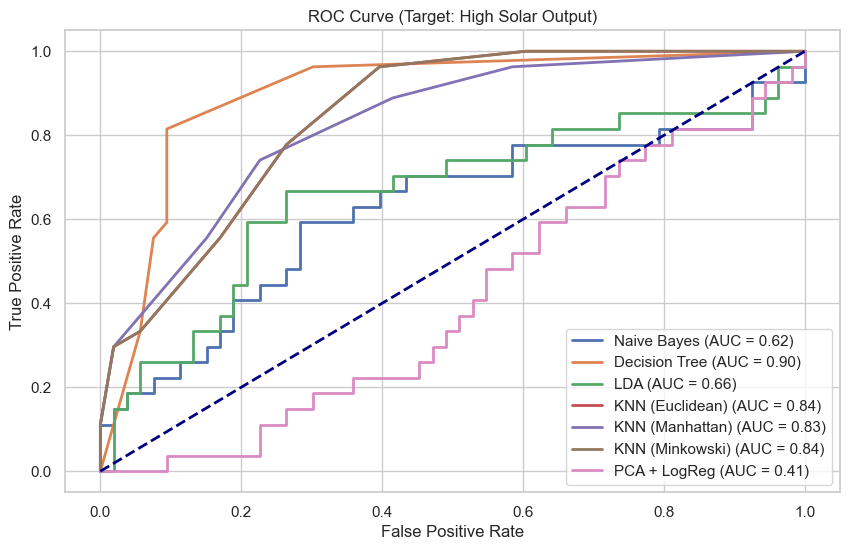


--- Cross Validation ---


,Model,Mean Accuracy,Std Dev
1,Decision Tree,0.660833,0.035730
4,KNN (Manhattan),0.610705,0.053014
3,KNN (Euclidean),0.598141,0.069022
5,KNN (Minkowski),0.598141,0.069022
0,Naive Bayes,0.474615,0.093674
2,LDA,0.456987,0.067180
6,PCA + LogReg,0.334038,0.071044


In [10]:
target_class_id = 2 
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(10, 6))

for name, data in results_data.items():
    model = data['model']

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test_bin[:, target_class_id], y_score[:, target_class_id])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Target: High Solar Output)')
plt.legend(loc="lower right")
plt.show()

# Cross Validation Table
print("\n--- Cross Validation ---")
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_summary = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    cv_summary.append({
        'Model': name, 
        'Mean Accuracy': scores.mean(), 
        'Std Dev': scores.std()
    })

display(pd.DataFrame(cv_summary).sort_values('Mean Accuracy', ascending=False))

# Phase II: Advanced Modeling & Analysis
---
**Objective:** Incorporating Linear Regression, SVD Visualization, Neural Networks, and deeper visualizations.

In [17]:
# STATISTICAL INTERPRETATION
from scipy.stats import chi2_contingency, f_oneway, ttest_ind

print("# --- 1. STATISTICAL HYPOTHESIS TESTING ---")

# A. Chi-Square Test (Independence between Temperature Bins & Solar Class)
contingency = pd.crosstab(df['Temp_Bin'], df['Solar_Class'])
chi2, p_chi, dof, ex = chi2_contingency(contingency)
print(f"\n[Chi-Square Test] P-Value: {p_chi:.5f}")
if p_chi < 0.05:
    print(">> RESULT: Statistically Significant.")
    print(">> INTERPRETATION: Temperature levels and Solar Output are dependent (related).")
else:
    print(">> RESULT: Not Significant (Independent).")

# B. ANOVA Test (Does Humidity differ across Low/Med/High Solar classes?)
groups = [df[df['Solar_Class'] == cls]['Humidity'] for cls in ['Low', 'Medium', 'High']]
f_stat, p_anova = f_oneway(*groups)
print(f"\n[ANOVA Test] P-Value: {p_anova:.5f}")
if p_anova < 0.05:
    print(">> RESULT: Statistically Significant.")
    print(">> INTERPRETATION: Humidity levels are significantly different between the Solar Classes.")
else:
    print(">> RESULT: Not Significant.")

# C. T-Test (Comparing Temperature of Low vs High Solar days)
group_low = df[df['Solar_Class'] == 'Low']['AvgTemp']
group_high = df[df['Solar_Class'] == 'High']['AvgTemp']
t_stat, p_ttest = ttest_ind(group_low, group_high)
print(f"\n[T-Test] P-Value: {p_ttest:.5f}")
if p_ttest < 0.05:
    print(">> RESULT: Statistically Significant.")
    print(">> INTERPRETATION: There is a significant temperature difference between Low and High solar output days.")
else:
    print(">> RESULT: Not Significant.")

# --- 1. STATISTICAL HYPOTHESIS TESTING ---

[Chi-Square Test] P-Value: 0.00249
>> RESULT: Statistically Significant.
>> INTERPRETATION: Temperature levels and Solar Output are dependent (related).

[ANOVA Test] P-Value: 0.00438
>> RESULT: Statistically Significant.
>> INTERPRETATION: Humidity levels are significantly different between the Solar Classes.

[T-Test] P-Value: 0.27706
>> RESULT: Not Significant.


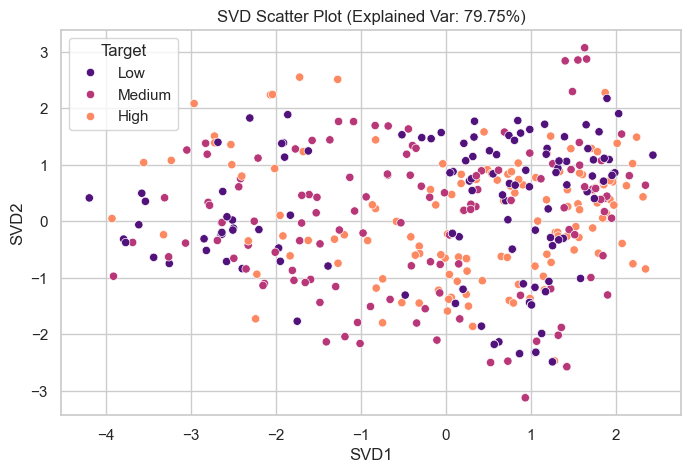

In [11]:
#  SVD Visualization 
from sklearn.decomposition import TruncatedSVD

# Calculate SVD
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_scaled)

# Create DataFrame for Plotting
svd_df = pd.DataFrame(X_svd, columns=['SVD1', 'SVD2'])
svd_df['Target'] = y_viz

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=svd_df, x='SVD1', y='SVD2', hue='Target', palette='magma')
plt.title(f"SVD Scatter Plot (Explained Var: {sum(svd.explained_variance_ratio_):.2%})")
plt.show()


--- LINEAR REGRESSION PREDICTION ---
R2 Score: 0.0896
RMSE: 7.32


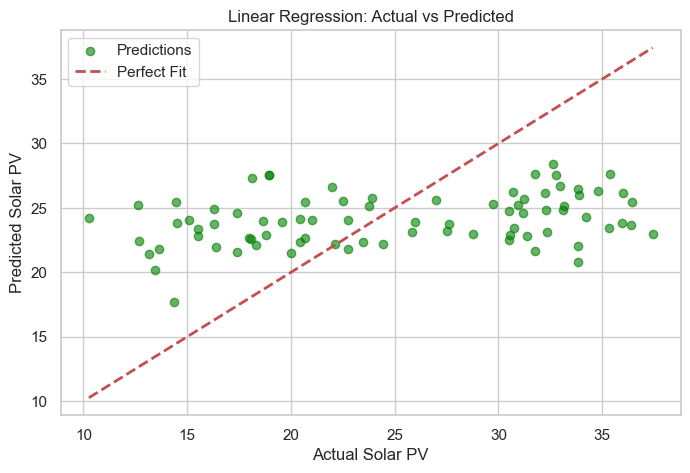

In [ ]:
# Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("\n--- LINEAR REGRESSION PREDICTION ---")

# 1. Setup Data 
feature_cols = ['AvgTemp', 'Humidity', 'Wind', 'Pressure', 'DewPoint', 'Month']
X_reg = df[feature_cols]
y_reg = df['Solar_PV']

# 2. Split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# 3. Train
lin_reg = LinearRegression()
lin_reg.fit(X_train_r, y_train_r)
y_pred_r = lin_reg.predict(X_test_r)

# 4. Results
print(f"R2 Score: {r2_score(y_test_r, y_pred_r):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_r)):.2f}")

# 5. Plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test_r, y_pred_r, alpha=0.6, color='green', label='Predictions')
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel("Actual Solar PV")
plt.ylabel("Predicted Solar PV")
plt.title("Linear Regression: Actual vs Predicted")
plt.legend()
plt.show()


--- PART 2: NEW MODEL RESULTS ---

Model: Neural Network
Test Acc:   30.00%
Error Rate: 70.00%
Precision:  0.2616
Recall:     0.3000
F1 Score:   0.2591
ROC:    0.4595


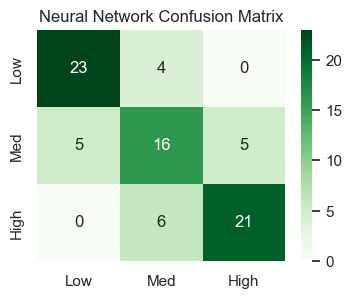


Model: Logistic Regression
Test Acc:   30.00%
Error Rate: 70.00%
Precision:  0.2616
Recall:     0.3000
F1 Score:   0.2591
ROC:    0.4595


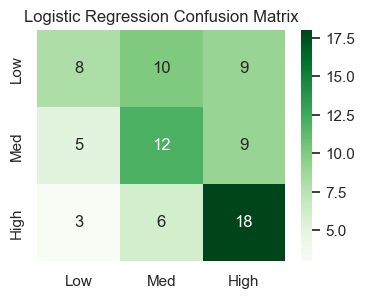

In [23]:
# Extra Models (Neural Net & Logistic) ---
from sklearn.neural_network import MLPClassifier

new_models = {
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial')
}

print("\n--- PART 2: NEW MODEL RESULTS ---")

for name, model in new_models.items():
    # Scale data for these specific models (Important!)
    scaler = StandardScaler()
    X_train_new = scaler.fit_transform(X_train)
    X_test_new = scaler.transform(X_test)
    
    # Train
    model.fit(X_train_new, y_train)
    y_pred_new = model.predict(X_test_new)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred_new)
    
    print(f"\nModel: {name}")
    print(f"Test Acc:   {test_acc:.2%}")
    print(f"Error Rate: {err:.2%}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1 Score:   {f1:.4f}")
    print(f"ROC:    {auc_val:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_new)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Low','Med','High'], yticklabels=['Low','Med','High'])
    plt.title(f"{name} Confusion Matrix")
    plt.show()

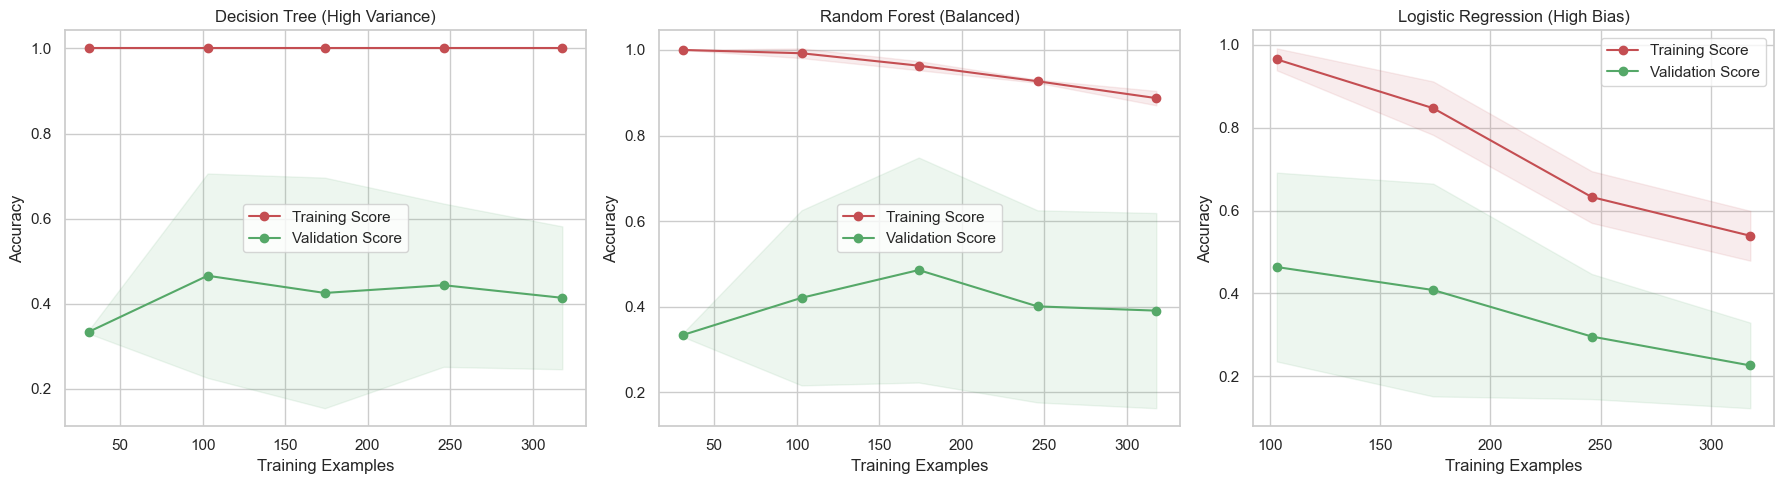


INTERPRETATION GUIDES:
1. Decision Tree: Large gap between Red (Train) and Green (Val) lines = OVERFITTING.
2. Logistic Regression: Both lines are low and close together = UNDERFITTING.
3. Random Forest: Gap is smaller than Decision Tree, and Green line is higher = BEST FIT.



In [18]:
# LEARNING CURVES 
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# We compare 3 distinct models
models_to_check = {
    'Decision Tree (High Variance)': DecisionTreeClassifier(max_depth=None, random_state=42),
    'Random Forest (Balanced)': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Logistic Regression (High Bias)': LogisticRegression(max_iter=1000)
}

plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(models_to_check.items()):
    plt.subplot(1, 3, i+1)
    
    # Calculate Curve data
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    # Statistics
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plotting
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation Score")
    
    # Fill gap
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    
    plt.title(name)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)

plt.tight_layout()
plt.show()

print("""
INTERPRETATION GUIDES:
1. Decision Tree: Large gap between Red (Train) and Green (Val) lines = OVERFITTING.
2. Logistic Regression: Both lines are low and close together = UNDERFITTING.
3. Random Forest: Gap is smaller than Decision Tree, and Green line is higher = BEST FIT.
""")

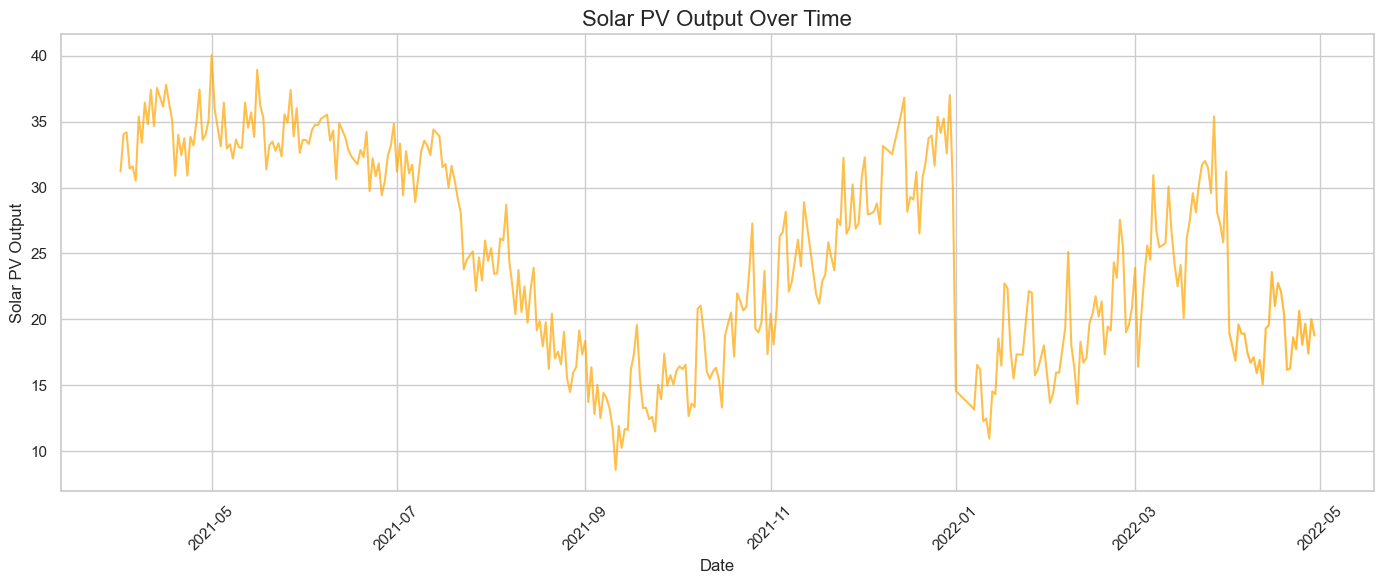

In [ ]:
# Solar PV over Time 
plt.figure(figsize=(14, 6))

# Plot the raw Solar PV data
sns.lineplot(data=df, x='Date', y='Solar_PV', color='orange', alpha=0.7)

plt.title('Solar PV Output Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Solar PV Output')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

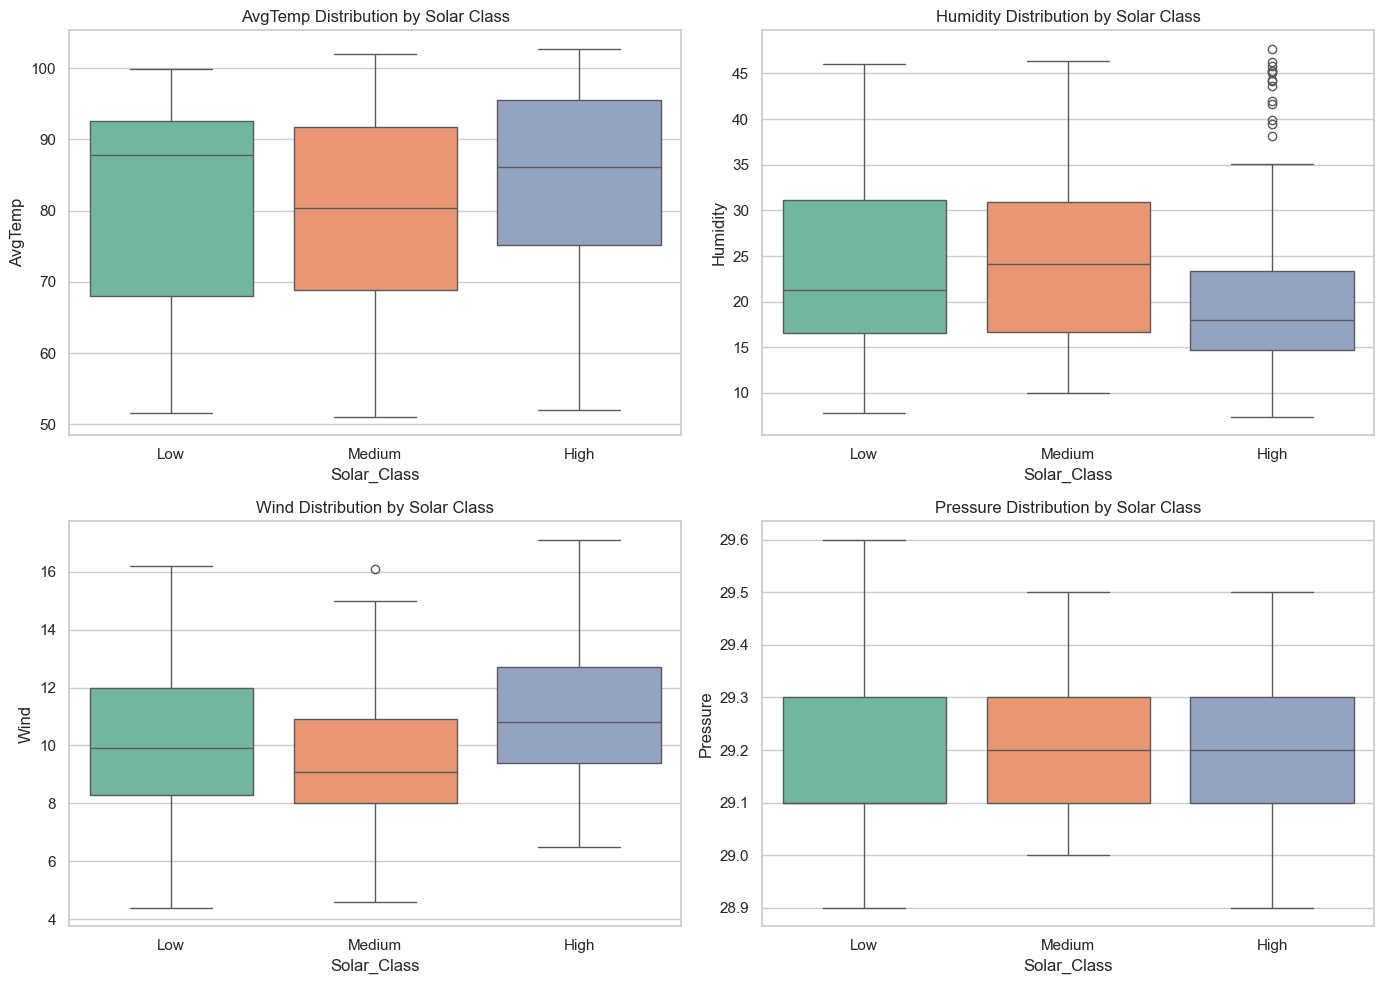

In [15]:
# Box Plots by Class 
features_to_plot = ['AvgTemp', 'Humidity', 'Wind', 'Pressure']

plt.figure(figsize=(14, 10))

for i, col in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    # Compare the distribution of each feature across the Solar Classes
    sns.boxplot(data=df, x='Solar_Class', y=col, palette='Set2', order=['Low', 'Medium', 'High'])
    plt.title(f'{col} Distribution by Solar Class')

plt.tight_layout()
plt.show()

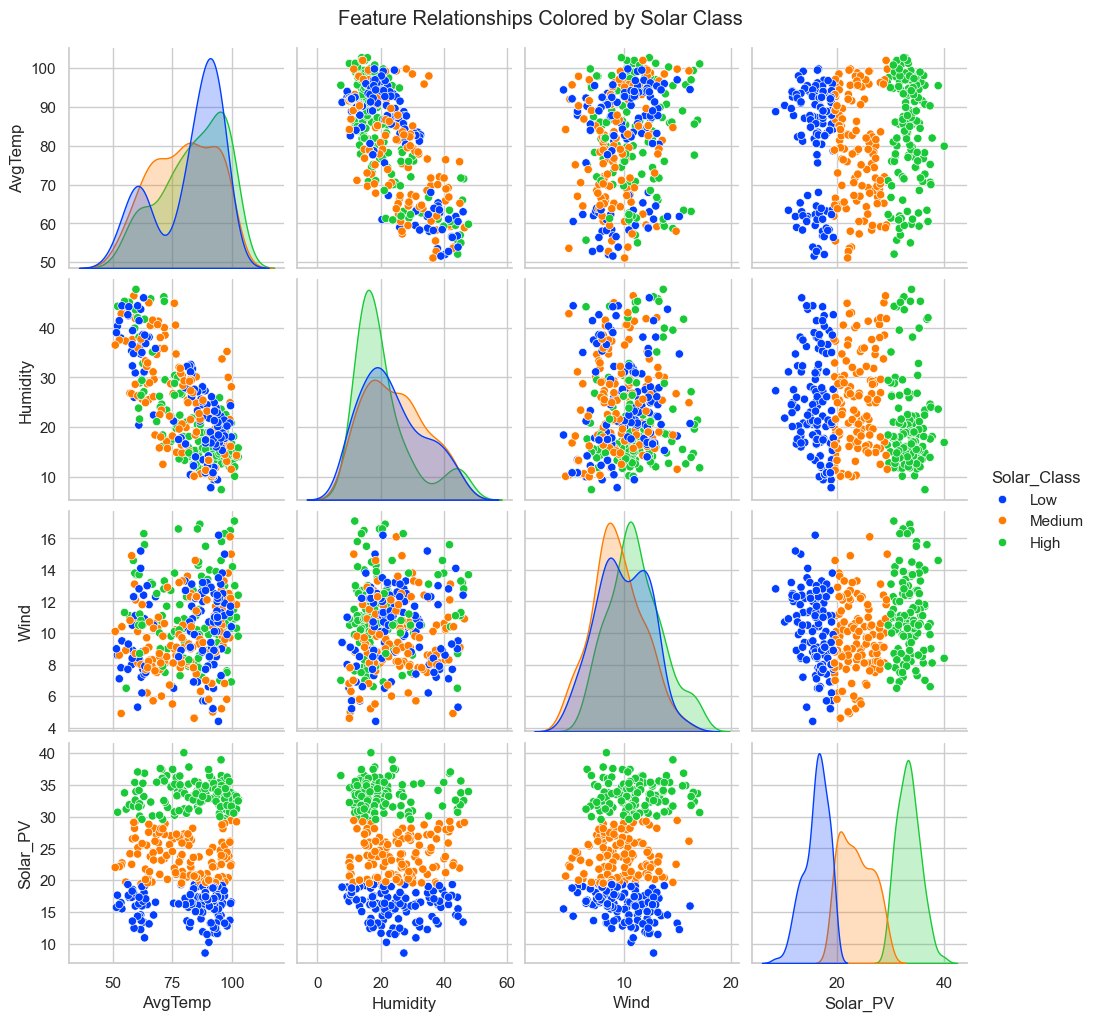

In [16]:
# Pair Plot 
cols_for_pairplot = ['AvgTemp', 'Humidity', 'Wind', 'Solar_PV', 'Solar_Class']

sns.pairplot(df[cols_for_pairplot], hue='Solar_Class', palette='bright', diag_kind='kde')
plt.suptitle('Feature Relationships Colored by Solar Class', y=1.02)
plt.show()